In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
data = pd.read_excel('DryBeanDataSet.xlsx')

def get_data():
    data = pd.read_excel('DryBeanDataSet.xlsx')
    data = data.replace('?', np.nan)
    return data



missing_values = data.eq("?").sum()
missing_values


data.shape

(13611, 22)

# Data types

### One hot encoding

In [3]:
# function that applies one hot encoding on categorical data
def one_hot_encode(data, column):
    return pd.get_dummies(data[column], prefix=column)

- convert all data types to numerical

# Missing data

In [4]:
import seaborn as sns

missing_values = data.isnull().sum()
missing_values
# sns.distplot(data['Compactness'])
# plt.title('Distribution of Compactness')
# plt.xlabel('Compactness')
# plt.ylabel('Density')
# plt.show()

# data['Compactness'].replace(np.nan, data['Compactness'].median(), inplace = True)

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
Constantness       0
EquivDiameter      0
Colour             0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
ShapeFactor5       0
ShapeFactor6       0
Class              0
Sort order         0
dtype: int64

# Class Imbalances

In [5]:
data['Class'].value_counts()
class_percentage = data['Class'].value_counts() / len(data) * 100
class_percentage.round(2)
# make this into a table with the class and the percentage of missing values
class_percentage = pd.DataFrame(class_percentage)
class_percentage.reset_index(inplace=True)
class_percentage.columns = ['Class', 'Percentage']
print(class_percentage.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Class & Percentage \\
\midrule
DERMASON & 26.023070 \\
SIRA & 19.351995 \\
SEKER & 14.877672 \\
HOROZ & 14.157667 \\
CALI & 11.960914 \\
BARBUNYA & 9.675997 \\
BOMBAY & 3.827786 \\
? & 0.124899 \\
\bottomrule
\end{tabular}



In [6]:
class_percentage = data['Colour'].value_counts() / len(data) * 100
class_percentage.round(2)
# make this into a table with the class and the percentage of missing values
class_percentage = pd.DataFrame(class_percentage)
class_percentage.reset_index(inplace=True)
class_percentage.columns = ['Colour', 'Percentage']
print(class_percentage.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Colour & Percentage \\
\midrule
brown & 44.926897 \\
black & 26.015723 \\
green & 14.862978 \\
white & 14.150320 \\
? & 0.044082 \\
\bottomrule
\end{tabular}



In [7]:
class_percentage = data['Constantness'].value_counts() / len(data) * 100
class_percentage.round(2)
# make this into a table with the class and the percentage of missing values
class_percentage = pd.DataFrame(class_percentage)
class_percentage.reset_index(inplace=True)
class_percentage.columns = ['Constantness', 'Percentage']
print(class_percentage.to_latex(index=False))

\begin{tabular}{rr}
\toprule
Constantness & Percentage \\
\midrule
1 & 90.287268 \\
0 & 9.712732 \\
\bottomrule
\end{tabular}



## Class and Colour distributions

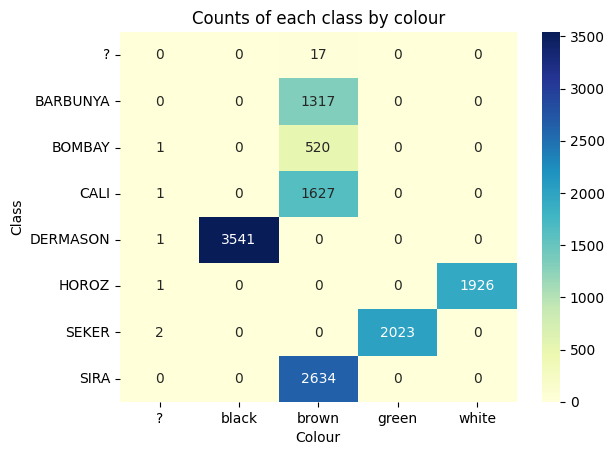

In [8]:
import seaborn as sns

# Create a pivot table
class_col_htmap = data.pivot_table(index='Class', columns='Colour', values='Area', aggfunc='count', fill_value=0, dropna=False)

# Plot the heatmap
# sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')

sns.heatmap(class_col_htmap, annot=True, cmap='YlGnBu', fmt='.0f')
plt.title('Counts of each class by colour')
plt.show()

In [9]:
class_col_htmap_missing = data.pivot_table(index='Class', columns='Colour', values='Area', aggfunc='count', fill_value=0, dropna=False)
class_col_htmap_missing

Colour,?,black,brown,green,white
Class,,,,,
?,0,0,17,0,0
BARBUNYA,0,0,1317,0,0
BOMBAY,1,0,520,0,0
CALI,1,0,1627,0,0
DERMASON,1,3541,0,0,0
HOROZ,1,0,0,0,1926
SEKER,2,0,0,2023,0
SIRA,0,0,2634,0,0


- Can impute missing colours very easily - easily see distributions
- Can't impute missing class given brown

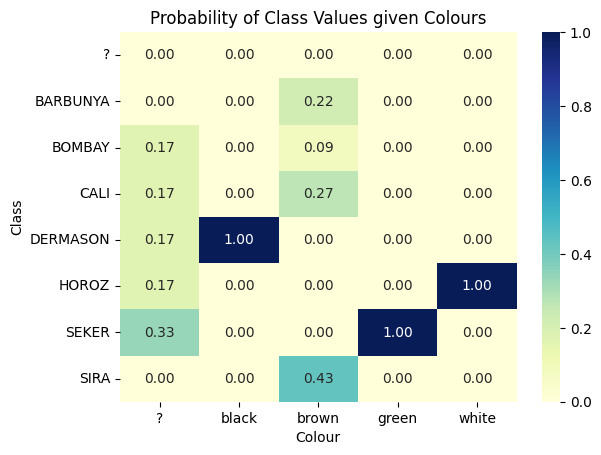

In [10]:
# Calculate the row sums
row_sums = class_col_htmap.sum(axis=0, skipna=True)
row_sums
# # Divide each value by the row sum and multiply by 100
prob_class_col = class_col_htmap.div(row_sums, axis=1) 
prob_class_col
# # Plot the heatmap
sns.heatmap(prob_class_col, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Probability of Class Values given Colours')
plt.show()

In [11]:
# fill in missing values for colours by using the probability of class values given colours

def remove_missing_colours(data):
    pv = data.pivot_table(index='Class', columns='Colour', values='Area', aggfunc='count', fill_value=0, dropna=False)

    row_sums = class_col_htmap.sum(axis=0, skipna=True)
    
    # # Divide each value by the row sum and multiply by 100
    prob_class_col = class_col_htmap.div(row_sums, axis=1) 
    prob_class_col.drop('?', axis=1, inplace=True)
    data['Colour'] = data['Colour'].replace('?', np.nan)

    data['Colour'] = data['Colour'].fillna(data['Class'].map(prob_class_col.idxmax(axis=1)))

    return data

remove_missing_colours(data)



,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,Constantness,EquivDiameter,Colour,...,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,ShapeFactor5,ShapeFactor6,Class,Sort order
0,84648,1132.054,439.915710,248.961941,1.767000,0.824453,86779,1,328.294351,brown,...,0.830027,0.746266,0.005197,0.000994,0.556914,3.487008,0.984066,50.809833,CALI,0.134791
1,39704,736.873,271.659919,186.481404,1.456767,0.727175,40106,1,224.839282,black,...,0.918880,0.82765,0.006842,0.001980,0.685004,1.242335,0.997891,148.508874,DERMASON,0.898848
2,35835,687.914,237.704180,192.176759,1.236904,0.588537,36190,1,213.603696,green,...,0.951588,0.898611,0.006633,0.002668,0.807503,2.813489,0.998803,82.107117,SEKER,0.539684
3,223035,1817.278,680.812555,419.994347,1.621004,0.787040,225889,1,532.894907,brown,...,0.848673,0.782734,0.003052,0.000707,0.612672,3.074472,0.993144,147.347735,BOMBAY,0.149130
4,41957,767.143,287.962974,186.166695,1.546802,0.762918,42310,1,231.130508,brown,...,0.895904,0.80264,0.006863,0.001757,0.644230,2.213954,0.996497,22.893826,SIRA,0.447635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,23018,578.382,203.761000,144.297607,1.412089,0.706041,23465,1,171.194123,black,...,0.864665,0.840171,0.008852,0.002721,0.705888,2.197446,0.996776,85.821969,DERMASON,0.764478
13607,69773,1095.057,387.116310,231.153291,1.674717,0.802155,71055,1,298.056610,brown,...,0.731179,0.769941,0.005548,0.001203,0.592809,1.004792,0.992787,152.980591,BARBUNYA,0.679735
13608,55773,968.988,347.920243,204.491191,1.701395,0.809040,57047,0,266.481499,brown,...,0.746444,0.765927,0.006238,0.001324,0.586644,2.219590,0.998113,102.437378,BARBUNYA,0.946849
13609,64235,1005.875,409.304636,201.686606,2.029409,0.870169,65018,1,285.983465,white,...,0.797799,0.698706,0.006372,0.000937,0.488190,2.078504,0.990736,174.754039,HOROZ,0.046135


### FIll in missing values for colours conditional on the class that each observation is in

In [12]:
priors_class = data['Class'].value_counts() / len(data)
brown_given_class = data.groupby('Class')['Colour'].agg(lambda x: (x == 'Brown').sum()) / data['Class'].value_counts()
brown_given_class

# Calculate the probability of each colour given class
def calculate_colour_probabilities(data):
    class_col_htmap = data.pivot_table(index='Class', columns='Colour', values='Area', aggfunc='count', fill_value=0)
    row_sums = class_col_htmap.sum(axis=0, skipna=True)
    prob_class_col = class_col_htmap.div(row_sums, axis=1)
    return prob_class_col

x = calculate_colour_probabilities(data)

# Calculate conditional probabilities of each Constantness conditional on the class


# get the value from x that matches the colour brown and class y
x.loc['DERMASON', 'brown']

np.float64(0.0)

In [13]:
# using bayes theorem with the prior and conditional probabilities find the class that has the highest probability for the missing values
def predict_class(data, missing):
    probs = {}
    priors_class = data['Class'].value_counts() / len(data)
    color_conditional = calculate_colour_probabilities(data)
    priors_color = data['Colour'].value_counts() / len(data)

    for i in data['Class'].dropna().unique():
        prior = priors_class[i]
        col = color_conditional.loc[i,missing['Colour']]
        priors= priors_color.loc[missing['Colour']]
        # prob = priors_class[i] * color_conditional.loc[missing['Colour'], i]/priors_color[missing['Colour']]
        probs[i] =  prior * col / priors
    # return the class with the highest probability
    return max(probs)
    

def fill_missing_class(data):
    missing = data[data['Class'].isnull()].index

    # run predict class for all missing class values
    for i in missing:
        data.at[i, 'Class'] = predict_class(data, data.loc[i])
    return data

data = fill_missing_class(data)

Missing values
- need to look at distribution of brown closer to determine missing values

## Class Distributions of all 3 for Brown

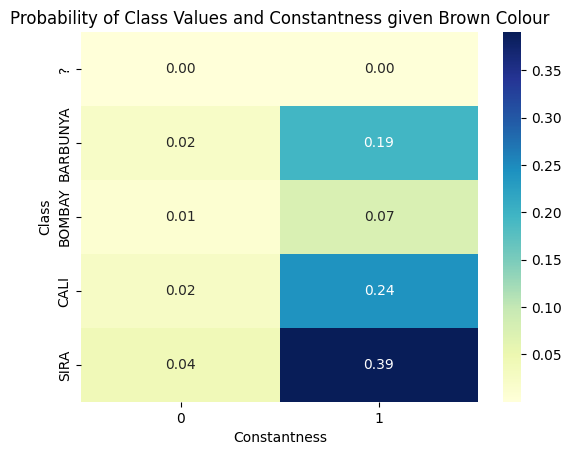

In [14]:
brown_data = data[data['Colour'] == 'brown']
class_dist = brown_data.pivot_table(index='Class', columns='Constantness', values='Area', aggfunc='count', fill_value=0)


class_dict_sum = class_dist.sum().sum()
class_dict_sum
brown_prob = class_dist.div(class_dict_sum, axis=1)

sns.heatmap(brown_prob, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Probability of Class Values and Constantness given Brown Colour')
plt.show()


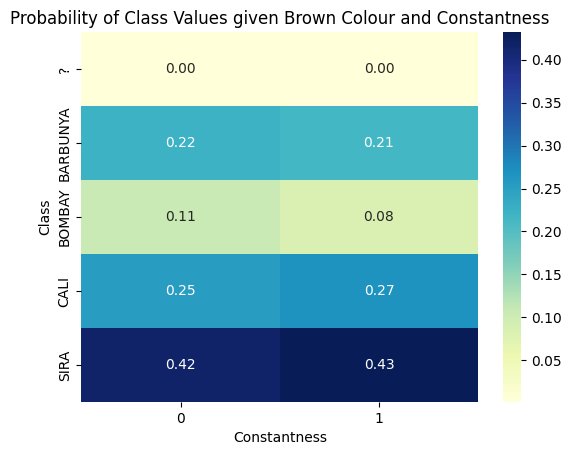

In [15]:

class_dict_sum = class_dist.sum(axis=0)
class_dict_sum
brown_prob = class_dist.div(class_dict_sum, axis=1)

sns.heatmap(brown_prob, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Probability of Class Values given Brown Colour and Constantness')
plt.show()

In [16]:
brown_data = data[data['Colour'] == 'brown']

# Outliers

## Drop negative values for ConvexArea 
Cant have negative values

In [17]:
df = data.drop(columns=['Class', 'Colour', 'Constantness'])
df.shape
# negative_values = df.lt(0).any()
df.drop(df[df['ConvexArea'] < 0].index, inplace=True)
df

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,ShapeFactor5,ShapeFactor6,Sort order
0,84648,1132.054,439.915710,248.961941,1.767000,0.824453,86779,328.294351,0.767184,0.975443,0.830027,0.746266,0.005197,0.000994,0.556914,3.487008,0.984066,50.809833,0.134791
1,39704,736.873,271.659919,186.481404,1.456767,0.727175,40106,224.839282,0.757739,0.989977,0.918880,0.82765,0.006842,0.001980,0.685004,1.242335,0.997891,148.508874,0.898848
2,35835,687.914,237.704180,192.176759,1.236904,0.588537,36190,213.603696,0.790885,0.990191,0.951588,0.898611,0.006633,0.002668,0.807503,2.813489,0.998803,82.107117,0.539684
3,223035,1817.278,680.812555,419.994347,1.621004,0.787040,225889,532.894907,0.761092,0.987365,0.848673,0.782734,0.003052,0.000707,0.612672,3.074472,0.993144,147.347735,0.149130
4,41957,767.143,287.962974,186.166695,1.546802,0.762918,42310,231.130508,0.721543,0.991657,0.895904,0.80264,0.006863,0.001757,0.644230,2.213954,0.996497,22.893826,0.447635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,23018,578.382,203.761000,144.297607,1.412089,0.706041,23465,171.194123,0.781994,0.980950,0.864665,0.840171,0.008852,0.002721,0.705888,2.197446,0.996776,85.821969,0.764478
13607,69773,1095.057,387.116310,231.153291,1.674717,0.802155,71055,298.056610,0.762446,0.981958,0.731179,0.769941,0.005548,0.001203,0.592809,1.004792,0.992787,152.980591,0.679735
13608,55773,968.988,347.920243,204.491191,1.701395,0.809040,57047,266.481499,0.765377,0.977668,0.746444,0.765927,0.006238,0.001324,0.586644,2.219590,0.998113,102.437378,0.946849
13609,64235,1005.875,409.304636,201.686606,2.029409,0.870169,65018,285.983465,0.77399,0.987957,0.797799,0.698706,0.006372,0.000937,0.488190,2.078504,0.990736,174.754039,0.046135


Clip outliers according to IQR

In [18]:
#Apply Winsorization to the data for outliers for each column using IQR caculation
def winsorize_data(data):
    for x in data.columns:
        q75, q25 = np.percentile(data[x], [75 ,25])
        iqr = q75 - q25
        min_val = q25 - (iqr*1.5)
        max_val = q75 + (iqr*1.5)
        data.loc[data[x] < min_val,x] = min_val
        data.loc[data[x] > max_val,x] = max_val
    return data

# winsorize_data(X)
X.columns

NameError: name 'X' is not defined

(13580, 20)

# Skewed Distributions

# Modelling Procedure

through pca analysis found 9 components to be optimal

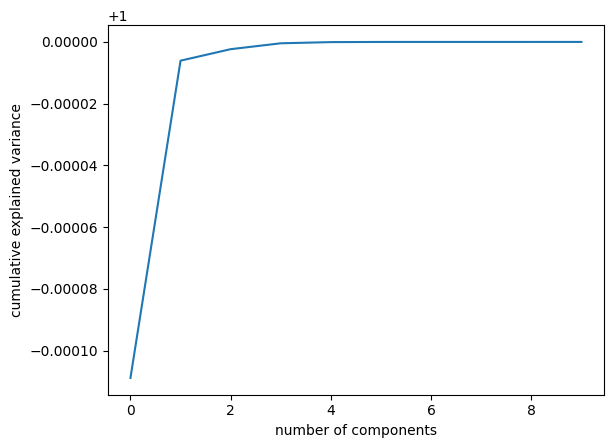

In [75]:
# draw explained variance plot for pca so that i can decide on optimal number of components






/var/folders/84/pgr0f22s293_z9t64z_cbfs00000gn/T/ipykernel_77003/4186376620.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace('?', np.nan)
/var/folders/84/pgr0f22s293_z9t64z_cbfs00000gn/T/ipykernel_77003/464937381.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1654.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data[x] < min_val,x] = min_val


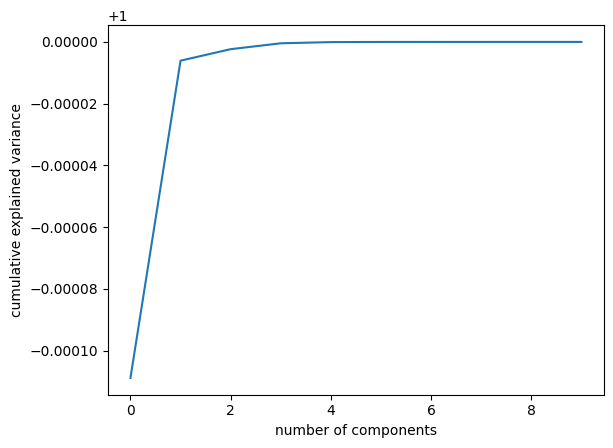

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'Constantness',
       'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness',
       'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4',
       'ShapeFactor5', 'ShapeFactor6', 'Sort order'],
      dtype='object')


In [77]:
def run_PCA(train, test, comp):

    # Create a pipeline that scales the data then creates a PCA
    pipe = Pipeline([('reducer', PCA(n_components=comp))])

    # Fit the pipeline to the training data
    pipe.fit(train)

    # Transform the training data
    train_pca = pipe.transform(train)

    # Transform the testing data
    test_pca = pipe.transform(test)

    return train_pca, test_pca

def get_train_test(X, y):

    # Split the data into a training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

    return X_train, X_test, y_train, y_test
data = get_data()
data = data.replace('?', np.nan)



data = remove_missing_colours(data)

data = fill_missing_class(data)

y = data['Class']
col = data['Colour']

data = winsorize_data(data.drop(columns=['Class', 'Colour']))



col = pd.get_dummies(col)

data.fillna(1, inplace=True)


# apply standard scalar
scaler = StandardScaler()
y = pd.get_dummies(y)
X = data
print(data.columns)
X = pd.concat([X, col], axis=1)
X_train, X_test, y_train, y_test = get_train_test(X, y)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

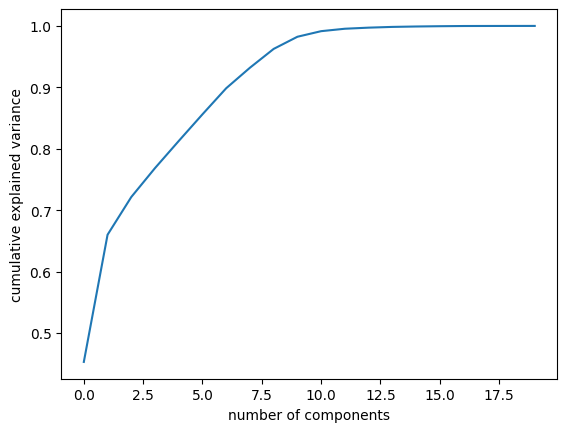

In [79]:

train_pca, test_pca = run_PCA(X_train, X_test, 15)
train_pca = pd.DataFrame(train_pca)
test_pca = pd.DataFrame(test_pca)
train_pca.reset_index(drop=True, inplace=True)
test_pca.reset_index(drop=True, inplace=True)
#run smote on Y-train in order to balance the classes
test_pca.shape

pca = PCA(n_components=20)
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [80]:
#run knn on train_pca with y_train and k=20
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier()
knn.fit(train_pca, y_train)
y_pred_train = knn.predict(train_pca)
y_pred = knn.predict(test_pca)

# calculate accuracy, precision, recall, f1 score for all labels
from sklearn.metrics import classification_report
print('Train report')
print(classification_report(y_train, y_pred_train))
print('Test report')
print(classification_report(y_test, y_pred))

knn.get_params()

report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose().round(2)
# drop the micro avg and macro avg rows
report.drop(['micro avg', 'macro avg'], inplace=True)
report


Train report
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      1054
           1       0.99      1.00      0.99       417
           2       0.95      0.97      0.96      1302
           3       1.00      1.00      1.00      2833
           4       1.00      1.00      1.00      1541
           5       1.00      1.00      1.00      1620
           6       0.98      0.99      0.99      2121

   micro avg       0.99      0.99      0.99     10888
   macro avg       0.98      0.98      0.98     10888
weighted avg       0.99      0.99      0.99     10888
 samples avg       0.99      0.99      0.99     10888

Test report
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       263
           1       1.00      1.00      1.00       104
           2       0.93      0.95      0.94       326
           3       1.00      1.00      1.00       709
           4       1.00      1.00      1.00       386

/Users/jackg/Documents/Uni/Fourth Year/ML/ML Repo/ML_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jackg/Documents/Uni/Fourth Year/ML/ML Repo/ML_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jackg/Documents/Uni/Fourth Year/ML/ML Repo/ML_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control

,precision,recall,f1-score,support
0,0.96,0.88,0.92,263.0
1,1.00,1.00,1.00,104.0
2,0.93,0.95,0.94,326.0
3,1.00,1.00,1.00,709.0
4,1.00,1.00,1.00,386.0
5,1.00,1.00,1.00,405.0
6,0.97,0.98,0.98,530.0
weighted avg,0.98,0.98,0.98,2723.0
samples avg,0.98,0.98,0.98,2723.0


In [82]:
# print the report to latex but ensure that only 2 decimal places are shown
print(report.to_latex())





\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.960000 & 0.880000 & 0.920000 & 263.000000 \\
1 & 1.000000 & 1.000000 & 1.000000 & 104.000000 \\
2 & 0.930000 & 0.950000 & 0.940000 & 326.000000 \\
3 & 1.000000 & 1.000000 & 1.000000 & 709.000000 \\
4 & 1.000000 & 1.000000 & 1.000000 & 386.000000 \\
5 & 1.000000 & 1.000000 & 1.000000 & 405.000000 \\
6 & 0.970000 & 0.980000 & 0.980000 & 530.000000 \\
weighted avg & 0.980000 & 0.980000 & 0.980000 & 2723.000000 \\
samples avg & 0.980000 & 0.980000 & 0.980000 & 2723.000000 \\
\bottomrule
\end{tabular}



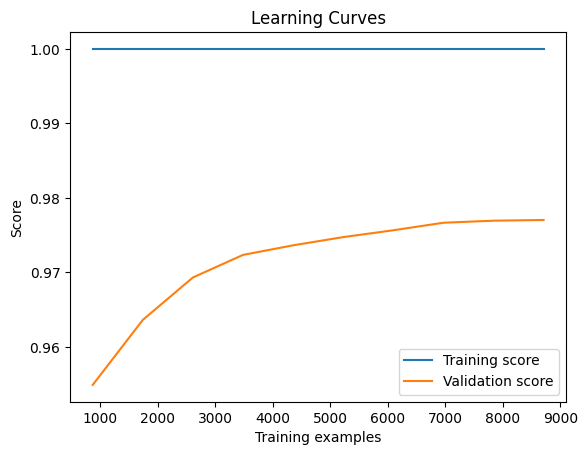

In [28]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(knn, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curves')
plt.show()

In [53]:
# run cross validation to determine optimal metric, neighbors and weights for knn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score


# define the parameter values that should be searched
k_range = list(range(5, 50))
metric = ['euclidean', 'manhattan', 'cosine']
weights = ['uniform', 'distance']


# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, metric=metric, weights=weights)

# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# fit the grid with data
grid.fit(train_pca, y_train)

# view the complete results
grid.cv_results_


/Users/jackg/Documents/Uni/Fourth Year/ML/ML Repo/ML_env/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'mean_fit_time': array([0.00964756, 0.00791693, 0.00808046, 0.00828347, 0.00799851,
        0.00791574, 0.00826349, 0.00866225, 0.00841372, 0.00800242,
        0.00804367, 0.00823803, 0.00800996, 0.00809195, 0.00799012,
        0.00803392, 0.00785036, 0.00800893, 0.00804777, 0.00805166,
        0.00791287, 0.00795286, 0.00834279, 0.00811179, 0.00829062,
        0.00799673, 0.00786748, 0.00876598, 0.00807109, 0.00781872,
        0.00828338, 0.00791552, 0.00791531, 0.00809562, 0.00820744,
        0.00824144, 0.00813711, 0.00797713, 0.00846975, 0.00820677,
        0.00791574, 0.00796149, 0.00807869, 0.00802605, 0.0080301 ,
        0.0080198 , 0.00803671, 0.00826225, 0.00882971, 0.00835552,
        0.00809541, 0.0082026 , 0.00822389, 0.0082444 , 0.00822306,
        0.00824242, 0.0081265 , 0.00777125, 0.00815091, 0.007936  ,
        0.00816526, 0.00806589, 0.00790291, 0.00790031, 0.00801864,
        0.00751104, 0.00747578, 0.00751562, 0.00806594, 0.00765529,
        0.00748162, 0.00749304,

In [54]:
grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}

In [81]:
# decision tree on train_pca with y_train
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()   
dt.fit(train_pca, y_train)
y_pred = dt.predict(test_pca)
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.89      0.87       263
           1       0.98      0.98      0.98       104
           2       0.92      0.88      0.90       326
           3       1.00      1.00      1.00       709
           4       0.99      0.99      0.99       386
           5       1.00      1.00      1.00       405
           6       0.96      0.96      0.96       530

   micro avg       0.97      0.97      0.97      2723
   macro avg       0.96      0.96      0.96      2723
weighted avg       0.97      0.97      0.97      2723
 samples avg       0.97      0.97      0.97      2723



In [74]:
# classification_report(y_test, y_pred)
# put the classification report into a dataframe so that i can turn it into a latex table
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose().round(2)  
# drop the micro avg and macro avg rows
report.drop(['micro avg', 'macro avg'], inplace=True)
report
print(report.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.890000 & 0.890000 & 0.890000 & 263.000000 \\
1 & 1.000000 & 1.000000 & 1.000000 & 104.000000 \\
2 & 0.920000 & 0.930000 & 0.920000 & 326.000000 \\
3 & 1.000000 & 1.000000 & 1.000000 & 709.000000 \\
4 & 1.000000 & 0.990000 & 0.990000 & 386.000000 \\
5 & 1.000000 & 0.990000 & 1.000000 & 405.000000 \\
6 & 0.970000 & 0.960000 & 0.970000 & 530.000000 \\
weighted avg & 0.970000 & 0.970000 & 0.970000 & 2723.000000 \\
samples avg & 0.970000 & 0.970000 & 0.970000 & 2723.000000 \\
\bottomrule
\end{tabular}



/Users/jackg/Documents/Uni/Fourth Year/ML/ML Repo/ML_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
# Grid search for decision tree
# define the parameter values that should be searched
criterion = ['entropy']
splitter = ['best']
min_samples_split = list(range(2, 10))
min_samples_leaf = list(range(1, 10))
max_depth = list(range(1, 10))


# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(criterion=criterion, splitter=splitter, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_depth=max_depth)

# instantiate the grid
grid = GridSearchCV(dt, param_grid, cv=10, scoring='f1_macro', n_jobs=-1)

# fit the grid with data
grid.fit(train_pca, y_train)

# view the complete results
grid.cv_results_

/Users/jackg/Documents/Uni/Fourth Year/ML/ML Repo/ML_env/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'mean_fit_time': array([0.19274492, 0.18663762, 0.17415056, 0.17908373, 0.19773633,
        0.20515079, 0.18167765, 0.17700992, 0.20604472, 0.20135355,
        0.16156697, 0.18105626, 0.25540242, 0.2544795 , 0.25704744,
        0.17737868, 0.1601532 , 0.2029489 , 0.17861521, 0.17463582,
        0.16499212, 0.16455352, 0.16298332, 0.1689944 , 0.16119313,
        0.16814313, 0.15926526, 0.15337293, 0.15229201, 0.16295598,
        0.16060002, 0.16020141, 0.22585232, 0.20143206, 0.19829156,
        0.2046881 , 0.19982152, 0.17598596, 0.15627391, 0.15926383,
        0.15649714, 0.16656103, 0.15776372, 0.1703532 , 0.16720641,
        0.17626543, 0.17521605, 0.18550024, 0.169047  , 0.1769017 ,
        0.18393102, 0.17340503, 0.16495693, 0.15936589, 0.1569324 ,
        0.172067  , 0.16804905, 0.15890708, 0.17153292, 0.15894499,
        0.16113656, 0.17732136, 0.24119608, 0.21164386, 0.20035777,
        0.18067873, 0.20319965, 0.16919351, 0.17175436, 0.1671454 ,
        0.18143897, 0.16847916,

In [44]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'splitter': 'best'}

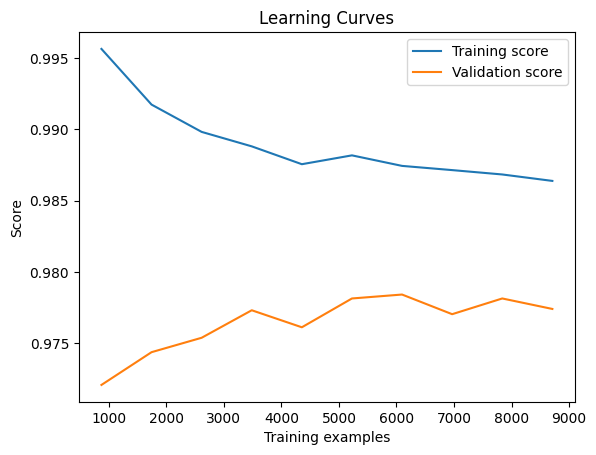

In [37]:
train_sizes, train_scores, test_scores = learning_curve(dt, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curves')
plt.show()